# Phân cụm khách hàng từ giao dịch (RFM + mở rộng)

Mục tiêu:
- Tạo đặc trưng RFM (Recency, Frequency, Monetary) và vài đặc trưng giao dịch cơ bản (AOV, Basket Size)
- Chuẩn hoá, chọn số cụm tối ưu (Elbow), huấn luyện KMeans
- Trực quan hoá hồ sơ cụm, các yếu tố ảnh hưởng và rút ra kết luận

Lưu ý hiệu năng: `transactions.csv` ~ 768MB sẽ được xử lý theo từng "chunk" để tiết kiệm RAM.



In [1]:
import os
import math
import gc
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pyodbc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score


In [3]:
conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=DAIHAITRAN;"
    "DATABASE=WEB_GFRS_DB;"
    "Trusted_Connection=yes;"
)

In [4]:
query1 = "select T.* from [dbo].[TRANSACTIONS] T"
query2 = "SELECT * FROM [dbo].[CUSTOMER]"
query3 = "SELECT * FROM [dbo].[PRODUCTS]"

# Tham số xử lý
CHUNK_SIZE = 500_000  # điều chỉnh nếu RAM hạn chế
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"transactions.csv ~ large file (chunked reading), chunk_size={CHUNK_SIZE}")


transactions.csv ~ large file (chunked reading), chunk_size=500000


In [5]:
# Hàm nhận diện cột theo tên gần đúng

def detect_columns(df: pd.DataFrame):
    cols = {c: c for c in df.columns}
    low = {c.lower().strip(): c for c in df.columns}
    def pick(cands):
        for k in cands:
            if k in low: return low[k]
        for k in low:
            for cand in cands:
                if cand in k:
                    return low[k]
        return None
    customer_col = pick([
        'customer id','customer_id','customerid','cust id','client id','client_id','user id','user_id'
    ])
    date_col = pick([
        'date','datetime','transaction date','invoice date','order date','purchase date','timestamp'
    ])
    qty_col = pick(['quantity','qty','units'])
    price_col = pick(['price','unit price','unit_price','list price','sale price','selling price'])
    total_col = pick(['total','amount','revenue','sales','gross','net'])
    discount_pct_col = pick(['discount pct','discount_pct','discount%','pct discount','rate discount'])
    discount_amt_col = pick(['discount amount','discount_amt','discount value'])
    product_col = pick(['product id','product_id','sku','item id','item_id'])
    store_col = pick(['store id','store_id','shop id'])

    return {
        'customer': customer_col,
        'date': date_col,
        'quantity': qty_col,
        'unit_price': price_col,
        'total': total_col,
        'discount_pct': discount_pct_col,
        'discount_amt': discount_amt_col,
        'product': product_col,
        'store': store_col,
    }

# Thử đọc vài dòng để nhận diện cột
sample = pd.read_sql_query(query1, conn)
colmap = detect_columns(sample)

# Ép dùng cột ngày đúng là 'FullDate' (thay vì DateID)
if 'FullDate' in sample.columns:
    colmap['date'] = 'FullDate'

colmap


{'customer': 'CustomerID',
 'date': 'DATE',
 'quantity': 'Quantity',
 'unit_price': 'UnitPrice',
 'total': 'LineTotal',
 'discount_pct': None,
 'discount_amt': None,
 'product': 'SKU',
 'store': None}

In [6]:
# Nạp bản đồ sản phẩm -> (Product ID) -> (Category, Sub Category)
products = None
prod_map = None
products = pd.read_sql_query(query3, conn)

# Chuẩn hoá tên cột để bắt đúng
prod_id_col = None
for c in products.columns:
    if c.lower().strip() in ['product id','product_id','sku','item id','item_id']:
        prod_id_col = c
        break
    if 'product' in c.lower():
        prod_id_col = c

cat_col = None
subcat_col = None
for c in products.columns:
    cl = c.lower().strip()
    if cl in ['category'] or 'category' in cl:
        if cat_col is None:
            cat_col = c
        elif subcat_col is None and c != cat_col:
            subcat_col = c

if prod_id_col is not None:
    keep_cols = [prod_id_col]
    if cat_col is not None:
        keep_cols.append(cat_col)
    if subcat_col is not None:
        keep_cols.append(subcat_col)

    # Lấy các cột cần thiết và đổi tên chuẩn
    products_small = products[keep_cols].copy()
    products_small.columns = ['ProductID', 'Category', 'SubCategory'][:len(keep_cols)]

    # Loại bỏ các ProductID trùng, giữ bản ghi đầu tiên
    products_small = products_small.drop_duplicates(subset=['ProductID'])

    # Tạo map ProductID -> {Category, SubCategory}
    prod_map = products_small.set_index('ProductID').to_dict(orient='index')

len(products) if products is not None else None, (list(products.columns)[:6] if products is not None else [])


(17940,
 ['ProductID', 'Category', 'SubCategory', 'Description', 'Color', 'Size'])

In [7]:
# Hàm tính tiền thuần từ 1 chunk

def compute_net_amount(df, colmap):
    qty = df[colmap['quantity']] if colmap['quantity'] in df.columns else 1
    net = None
    if colmap['total'] in df.columns:
        net = df[colmap['total']].astype(float)
    else:
        unit = None
        if colmap['unit_price'] in df.columns:
            unit = df[colmap['unit_price']].astype(float)
        elif 'price' in [c.lower() for c in df.columns]:
            # fallback tìm cột chứa 'price'
            for c in df.columns:
                if 'price' in c.lower():
                    unit = df[c].astype(float)
                    break
        if unit is not None:
            net = unit * qty
    # Giảm theo chiết khấu nếu có
    if net is None:
        net = pd.Series(0.0, index=df.index)
    if colmap['discount_pct'] in df.columns:
        pct = pd.to_numeric(df[colmap['discount_pct']], errors='coerce').fillna(0).clip(lower=0, upper=1)
        net = net * (1 - pct)
    if colmap['discount_amt'] in df.columns:
        amt = pd.to_numeric(df[colmap['discount_amt']], errors='coerce').fillna(0)
        net = (net - amt).clip(lower=0)
    return net

# Bộ gom cho từng khách hàng
from collections import defaultdict

agg = {
    'last_date': defaultdict(lambda: pd.Timestamp.min),
    'freq': defaultdict(int),
    'monetary': defaultdict(float),
    'quantity': defaultdict(float),
}
# đếm theo Category/SubCategory (nếu map sp khả dụng)
cat_counts = defaultdict(lambda: defaultdict(int))  # customer -> {Category: count}
subcat_counts = defaultdict(lambda: defaultdict(int))

# Dò type ngày để parse
date_parser = None
if colmap['date'] is not None:
    date_parser = [colmap['date']]

# Đọc theo chunk trực tiếp từ SQL Server
# Sử dụng pandas.read_sql_query với tham số chunksize
reader = pd.read_sql_query(
    query1,
    conn,
    chunksize=CHUNK_SIZE,
    parse_dates=date_parser if date_parser else None,
)

cust_col = colmap['customer']
prod_col = colmap['product']
qty_col = colmap['quantity']

for i, chunk in enumerate(reader, start=1):
    # Bảo đảm kiểu
    if cust_col is None or cust_col not in chunk.columns:
        raise ValueError('Không tìm thấy cột Customer ID trong transactions.')
    if colmap['date'] and colmap['date'] in chunk.columns and not np.issubdtype(chunk[colmap['date']].dtype, np.datetime64):
        chunk[colmap['date']] = pd.to_datetime(chunk[colmap['date']], errors='coerce')

    # Net amount và quantity
    net = compute_net_amount(chunk, colmap)
    q = pd.to_numeric(chunk[qty_col], errors='coerce').fillna(0) if qty_col in chunk.columns else pd.Series(1, index=chunk.index)

    # Cập nhật tổng hợp
    cust = chunk[cust_col]
    # Lần mua gần nhất
    if colmap['date'] and colmap['date'] in chunk.columns:
        dt = chunk[colmap['date']]
        for cid, d in zip(cust, dt):
            if pd.notnull(d) and d > agg['last_date'][cid]:
                agg['last_date'][cid] = d
    # Frequency, Monetary, Quantity
    for cid, n, qq in zip(cust, net, q):
        agg['freq'][cid] += 1
        agg['monetary'][cid] += float(n) if pd.notnull(n) else 0.0
        agg['quantity'][cid] += float(qq) if pd.notnull(qq) else 0.0

    # Đếm category nếu có product mapping
    if prod_map is not None and prod_col in chunk.columns:
        for cid, pid in zip(cust, chunk[prod_col]):
            info = prod_map.get(pid)
            if info:
                cat = info.get('Category')
                subc = info.get('SubCategory')
                if cat:
                    cat_counts[cid][cat] += 1
                if subc:
                    subcat_counts[cid][subc] += 1

    if i % 5 == 0:
        print(f"Đã xử lý {i} chunks")

print("Hoàn tất gom giao dịch")

# Biến về DataFrame RFM
rfm = pd.DataFrame({
    'CustomerID': list(agg['freq'].keys()),
})
rfm['Frequency'] = rfm['CustomerID'].map(agg['freq'])
rfm['Monetary'] = rfm['CustomerID'].map(agg['monetary'])
rfm['Quantity'] = rfm['CustomerID'].map(agg['quantity'])
rfm['LastDate'] = rfm['CustomerID'].map(agg['last_date'])

# Recency tính theo ngày so với ngày lớn nhất
# Đảm bảo LastDate là datetime, nếu không có ngày hợp lệ thì Recency = NaN
if 'LastDate' in rfm.columns:
    rfm['LastDate'] = pd.to_datetime(rfm['LastDate'], errors='coerce')
    if rfm['LastDate'].notna().any():
        max_date = rfm['LastDate'].max()
        rfm['Recency'] = (max_date - rfm['LastDate']).dt.days.astype('float')
    else:
        print("[Cảnh báo] Không có giá trị ngày hợp lệ trong LastDate, Recency sẽ = NaN")
        rfm['Recency'] = np.nan
else:
    print("[Cảnh báo] Không tìm thấy cột LastDate trong rfm, Recency sẽ = NaN")
    rfm['Recency'] = np.nan

rfm['AOV'] = (rfm['Monetary'] / rfm['Frequency']).replace([np.inf, -np.inf], np.nan).fillna(0)
rfm['AvgBasketSize'] = (rfm['Quantity'] / rfm['Frequency']).replace([np.inf, -np.inf], np.nan).fillna(0)

rfm.head(), rfm.describe(include='all').T.head(10)


Đã xử lý 5 chunks
Đã xử lý 10 chunks
Hoàn tất gom giao dịch


(   CustomerID  Frequency  Monetary  Quantity            LastDate  Recency  \
 0       47162         10     429.0      10.0 2025-02-01 20:36:00     45.0   
 1       10142         13     313.0      13.0 2024-12-27 09:47:00     81.0   
 2        1968         10     186.0      10.0 2024-05-06 20:40:00    316.0   
 3      265336          3      63.0       3.0 2024-12-29 11:34:00     79.0   
 4       14906         37    1217.0      40.0 2025-02-05 20:23:00     41.0   
 
          AOV  AvgBasketSize  
 0  42.900000       1.000000  
 1  24.076923       1.000000  
 2  18.600000       1.000000  
 3  21.000000       1.000000  
 4  32.891892       1.081081  ,
                    count                           mean                  min  \
 CustomerID     1283707.0                  778749.818241                  1.0   
 Frequency      1283707.0                       4.998669                  1.0   
 Monetary       1283707.0                     220.016339              -1493.0   
 Quantity       128

In [8]:
rfm = rfm.sort_values(by='CustomerID')
rfm

,CustomerID,Frequency,Monetary,Quantity,LastDate,Recency,AOV,AvgBasketSize
74295,1,8,363.0,11.0,2024-12-07 16:00:00,101.0,45.375000,1.375000
33105,2,10,553.0,13.0,2025-02-13 17:33:00,33.0,55.300000,1.300000
48146,3,3,137.0,3.0,2024-05-26 20:35:00,296.0,45.666667,1.000000
40006,4,4,128.0,4.0,2023-10-09 12:06:00,526.0,32.000000,1.000000
8277,5,19,1029.0,21.0,2024-11-27 17:42:00,111.0,54.157895,1.105263
...,...,...,...,...,...,...,...,...
1257903,1643293,3,57.0,3.0,2023-09-08 14:58:00,557.0,19.000000,1.000000
1220782,1643294,3,146.0,3.0,2024-10-19 12:03:00,150.0,48.666667,1.000000
1283389,1643297,4,0.0,4.0,2024-11-27 16:20:00,111.0,0.000000,1.000000
1283550,1643302,1,17.0,1.0,2024-12-25 15:35:00,83.0,17.000000,1.000000


In [9]:

# Chuẩn bị dữ liệu cho phân cụm
# Lựa chọn đặc trưng cốt lõi + bổ sung
base_features = ['Recency','Frequency','Monetary','AOV','AvgBasketSize']
use_features = base_features

X = rfm[use_features].copy()

# Làm sạch giá trị bất thường/inf/NaN và cắt đuôi phân phối
# - cap Monetary trước khi log1p
if 'Monetary' in X.columns and X['Monetary'].notna().any():
    m_cap = X['Monetary'].quantile(0.999)
    if pd.notna(m_cap):
        X['Monetary'] = np.clip(X['Monetary'], 0, m_cap)
X['Monetary'] = np.log1p(X['Monetary'].clip(lower=0))

# - Recency cap trước khi sqrt
if 'Recency' in X.columns and X['Recency'].notna().any():
    r_cap = X['Recency'].quantile(0.999)
    if pd.notna(r_cap):
        X['Recency'] = np.clip(X['Recency'], 0, r_cap)
X['Recency'] = np.sqrt(np.clip(X['Recency'], a_min=0, a_max=None))

# - Clip các cột còn lại ở 99.9% để giảm outlier cực đoan
for col in [c for c in ['Frequency','AOV','AvgBasketSize'] if c in X.columns]:
    if X[col].notna().any():
        cap = X[col].quantile(0.999)
        if pd.notna(cap):
            X[col] = np.clip(X[col], 0, cap)

# Thay thế inf/na còn lại
X = X.replace([np.inf, -np.inf], np.nan)
for col in X.columns:
    med = X[col].median(skipna=True)
    if pd.isna(med):
        med = 0.0
    X[col] = X[col].fillna(med)

# Đảm bảo dtype float64
X = X.astype('float64')

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X.shape, X_scaled[:3]

((1283707, 5),
 array([[-0.18559725,  0.8       ,  0.59104873,  0.115     ,  6.75      ],
        [-0.63392888,  1.2       ,  0.88182828,  0.512     ,  5.4       ],
        [ 0.55946168, -0.2       , -0.08042716,  0.12666667,  0.        ]]))

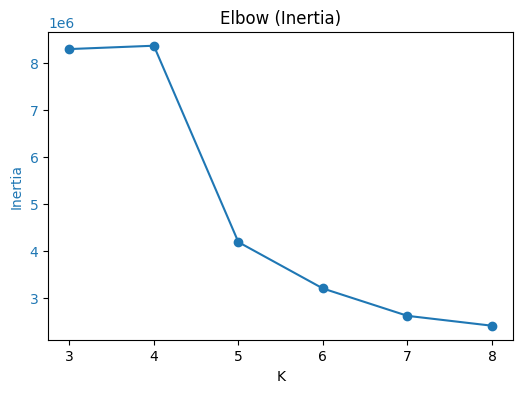

[(3, 8293270.75262171),
 (4, 8364561.527404388),
 (5, 4183022.825831518),
 (6, 3195057.659000025),
 (7, 2612599.4418949075),
 (8, 2402212.39994056)]

In [10]:
# Chọn K tối ưu (Elbow + Silhouette) với MiniBatchKMeans cho nhanh
inertias = []
K_range = list(range(3, 9))

for k in K_range:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, batch_size=4096)
    labels = mbk.fit_predict(X_scaled)
    inertias.append(mbk.inertia_)
    idx = np.random.choice(X_scaled.shape[0], 30000, replace=False)

fig, ax1 = plt.subplots(1,1, figsize=(6,4))
color = 'tab:blue'
ax1.plot(K_range, inertias, '-o', color=color)
ax1.set_xlabel('K')
ax1.set_ylabel('Inertia', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Elbow (Inertia)')
plt.show()


list(zip(K_range, inertias))


In [11]:
# Fit mô hình KMeans cuối cùng (chọn K thủ công nếu muốn)
K_FINAL = 4  # có thể thay đổi sau khi xem biểu đồ
kmeans = MiniBatchKMeans(n_clusters=K_FINAL, random_state=RANDOM_STATE, batch_size=4096)
labels = kmeans.fit_predict(X_scaled)
rfm['Cluster'] = labels

rfm.groupby('Cluster')[['Recency','Frequency','Monetary','AOV','AvgBasketSize']].mean().round(2)


,Recency,Frequency,Monetary,AOV,AvgBasketSize
Cluster,,,,,
0,178.01,5.60,245.40,49.86,1.00
1,262.93,2.79,201.63,83.89,2.03
2,329.65,2.01,47.26,27.63,1.00
3,142.87,8.47,419.48,52.91,1.28


In [12]:
rfm

,CustomerID,Frequency,Monetary,Quantity,LastDate,Recency,AOV,AvgBasketSize,Cluster
74295,1,8,363.0,11.0,2024-12-07 16:00:00,101.0,45.375000,1.375000,3
33105,2,10,553.0,13.0,2025-02-13 17:33:00,33.0,55.300000,1.300000,3
48146,3,3,137.0,3.0,2024-05-26 20:35:00,296.0,45.666667,1.000000,0
40006,4,4,128.0,4.0,2023-10-09 12:06:00,526.0,32.000000,1.000000,2
8277,5,19,1029.0,21.0,2024-11-27 17:42:00,111.0,54.157895,1.105263,3
...,...,...,...,...,...,...,...,...,...
1257903,1643293,3,57.0,3.0,2023-09-08 14:58:00,557.0,19.000000,1.000000,2
1220782,1643294,3,146.0,3.0,2024-10-19 12:03:00,150.0,48.666667,1.000000,0
1283389,1643297,4,0.0,4.0,2024-11-27 16:20:00,111.0,0.000000,1.000000,2
1283550,1643302,1,17.0,1.0,2024-12-25 15:35:00,83.0,17.000000,1.000000,2


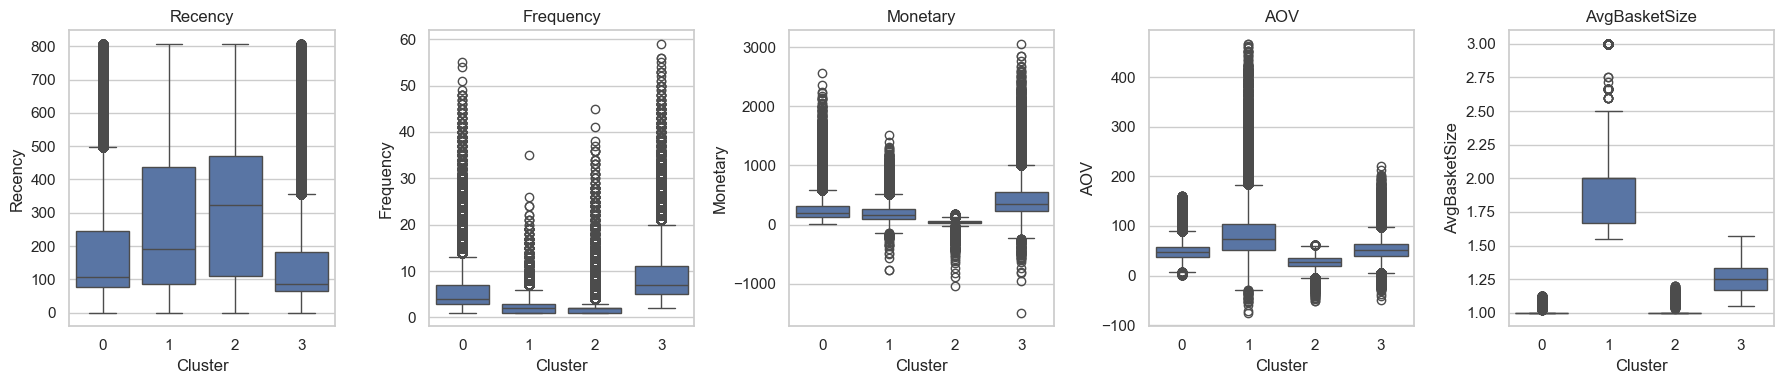

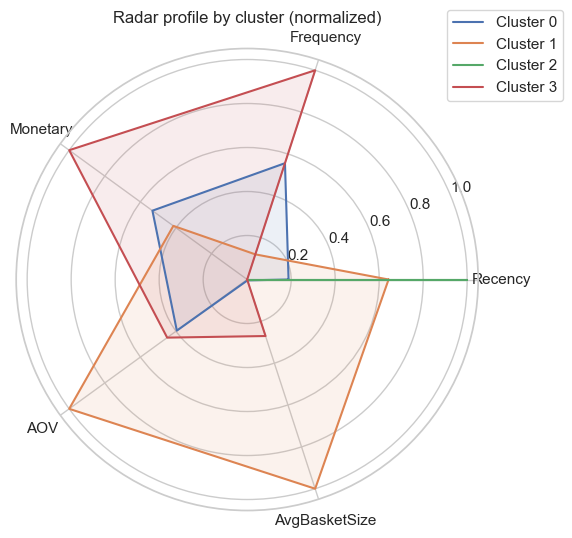

In [13]:
# Trực quan hoá hồ sơ cụm và các yếu tố ảnh hưởng
sns.set_theme(style='whitegrid')

# Boxplot động cho các feature chính (bao gồm feature mới nếu có)
plot_cols = ['Recency','Frequency','Monetary','AOV','AvgBasketSize']
plot_cols += [c for c in ['CategoryEntropy','CategoryCount','PurchaseIntensity'] if c in rfm.columns]

n = len(plot_cols)
cols = 5
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(18, 4*rows))
axes = np.atleast_1d(axes).ravel()
for ax, col in zip(axes, plot_cols):
    sns.boxplot(data=rfm, x='Cluster', y=col, ax=ax)
    ax.set_title(col)
for ax in axes[n:]:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Radar plot: trung bình normalize mỗi cụm (bao gồm feature mới)
feat_for_radar = ['Recency','Frequency','Monetary','AOV','AvgBasketSize']
feat_for_radar += [c for c in ['CategoryEntropy','CategoryCount','PurchaseIntensity'] if c in rfm.columns]
radar = rfm.groupby('Cluster')[feat_for_radar].mean()
radar_norm = (radar - radar.min()) / (radar.max() - radar.min() + 1e-9)

angles = np.linspace(0, 2*np.pi, len(feat_for_radar), endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
for cl in radar_norm.index:
    vals = radar_norm.loc[cl].values
    vals = np.concatenate([vals, [vals[0]]])
    ax.plot(angles, vals, label=f'Cluster {cl}')
    ax.fill(angles, vals, alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feat_for_radar)
ax.set_title('Radar profile by cluster (normalized)')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()



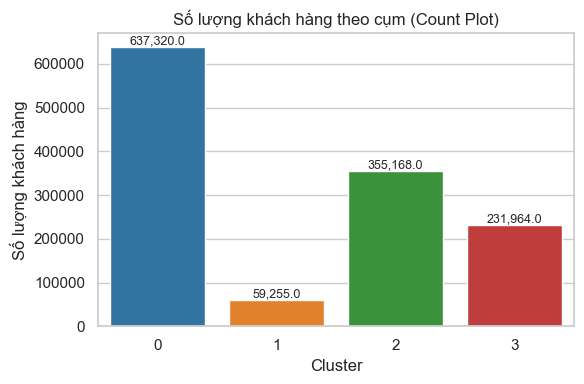

In [14]:
# A. Count Plot: Số lượng khách hàng trong từng cụm
sns.set_theme(style='whitegrid')

plt.figure(figsize=(6,4))
ax = sns.countplot(data=rfm, x='Cluster', palette='tab10')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,}', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, rotation=0)
ax.set_title('Số lượng khách hàng theo cụm (Count Plot)')
ax.set_xlabel('Cluster')
ax.set_ylabel('Số lượng khách hàng')
plt.tight_layout()
plt.show()


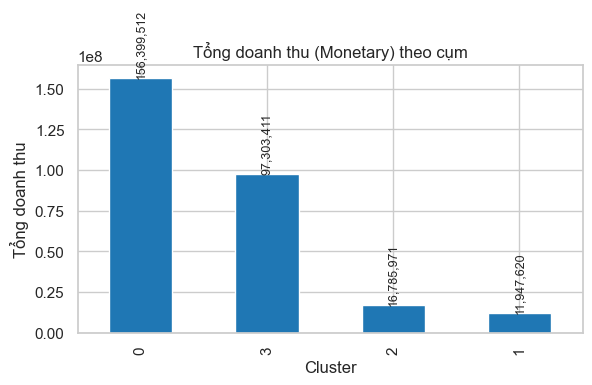

,RevenueShare
Cluster,
0,0.553751
3,0.344514
2,0.059433
1,0.042302


In [15]:
# B. Tổng doanh thu (Monetary) theo cụm
monetary_sum = rfm.groupby('Cluster')['Monetary'].sum().sort_values(ascending=False)

plt.figure(figsize=(6,4))
ax = monetary_sum.plot(kind='bar', color='tab:blue')
for i, v in enumerate(monetary_sum.values):
    ax.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9, rotation=90)
ax.set_title('Tổng doanh thu (Monetary) theo cụm')
ax.set_xlabel('Cluster')
ax.set_ylabel('Tổng doanh thu')
plt.tight_layout()
plt.show()

monetary_share = (monetary_sum / monetary_sum.sum()).to_frame('RevenueShare')
monetary_share


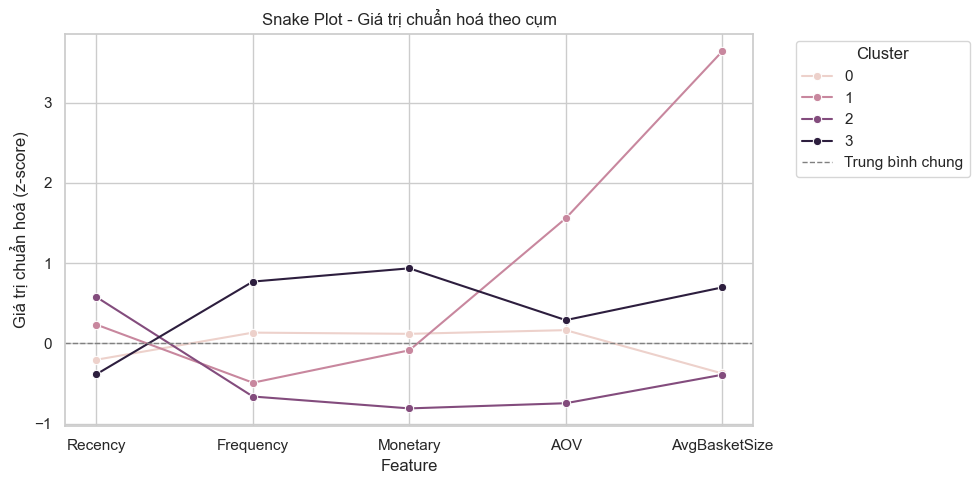

In [16]:
# C. Snake Plot: so sánh giá trị chuẩn hoá giữa các cụm
from sklearn.preprocessing import StandardScaler

snake_features = ['Recency','Frequency','Monetary','AOV','AvgBasketSize']

scaler_snake = StandardScaler()
X_snake = scaler_snake.fit_transform(rfm[snake_features])

snake_df = pd.DataFrame(X_snake, columns=snake_features)
snake_df['Cluster'] = rfm['Cluster'].values

snake_long = snake_df.groupby('Cluster')[snake_features].mean().reset_index().melt(
    id_vars='Cluster', var_name='Feature', value_name='StandardizedValue'
)

global_mean = pd.Series(0, index=snake_features)

plt.figure(figsize=(10,5))
ax = sns.lineplot(data=snake_long, x='Feature', y='StandardizedValue', hue='Cluster', marker='o')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, label='Trung bình chung')
ax.set_title('Snake Plot - Giá trị chuẩn hoá theo cụm')
ax.set_ylabel('Giá trị chuẩn hoá (z-score)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
